# An optimal test for strategic interaction in social and economic network formation between heterogeneous agents: Python Jupyter Notebook 2
Andrin Pelican, Bryan Graham - University of California - Berkeley

November 2021, Revised May 2022

### Code citation:

Graham, Bryan S. and Andrin Pelican (2021). "An optimal test for strategic interaction in social and economic network formation between heterogeneous agents: Python Jupyter Notebook 2," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 18 November 2021)

This notebook illustrates how to use the Python package **ugd**, for *uniform graph draw*, created in conjunction with the paper _An optimal test for strategic interaction in social and economic network formation between heterogeneous agents_ by Andrin Pelican and Bryan Graham (a draft of the paper is available online at https://arxiv.org/abs/2009.00212). This notebook also replicates the empirical application presented in the paper. Some figures and illustrations which appear in the paper are also reproduced in this notebook.

In [1]:
from platform import python_version
print(python_version())

3.6.13


In order to run the code is this Notebook you will need to install the package **ugd**. The GitHub repository page for this package is https://github.com/AndrinPelican/ugd. The package's PyPi page is https://pypi.org/project/ugd/.   

Users of Anaconda sometimes get conflicts when installing packages with both conda and pip (the **ugd** package is currently only available for installation via pip). The latest installation of Anaconda also may result in backwards compatibility issues with **ugd**. For these reasons we recommend creating a Python virtual environment in which **ugd** and a few dependent packages are installed. Additional packages can be installed in this environment if also needed for research purposes (e.g., **pandas**).    

The following series of commands (executed from the command line) create a Python virtual environment with all the relevant package dependences required by **ugd**. Proceeding in this way ensures that an existing Python environment is not accidently "messed up" when trying to install **ugd**.

conda create -n netsim python=3.6    
conda activate netsim    
pip install --user ipykernel    
python -m ipykernel install --user --name=netsim    
pip install ugd    
pip install numpy    
pip install python-igraph    
pip install cairocffi    

After executing these commands open this notebook and execute it with the "netsim" kernel (which should now be available from the "Kernel" drop down menu in Jupyter).

We begin by loading all required packages. The **ugd** package, for *uniform graph draw*, is the one created in conjuction with the paper. Change the graphics directory below to whereever you would like to save figures to on your local filesystem.    

You will also need the *Nyakatoke_ArcList.npy* and *Nyakatoke_Attributes.npy* pickle files. They are included in the GitHub repository associated with the paper. Download them to your local machine and change the "data" directory below to point to the appropriate location on your computer.

In [1]:
# load modules

#import ugd
import numpy as np
import igraph
import matplotlib.pyplot as plt
import itertools

# Directory where graphics files will be saved
graphics =  '/Users/bgraham/Dropbox/Replication/Testing_Networks/Graphics/'

# Directory where data files are stored
data =  '/Users/bgraham/Dropbox/Replication/Testing_Networks/Data/'

An alternative to installing the **ugd** package in a virtual environment is to make a local copy of the course code (available of GitHub) and manually load it using the code snippet below. Note you will need to change the sys.path.append directory to the location of the **udg** module files on your local system. This approach can be useful for useful who may wish to adapt/modify **ugd** source code.

In [2]:
# Append location of ugd module base directory to system path
# NOTE: only required if permanent install of **ugd** is not made. This works if you copy the **ugd** 
#       module to you local machine from GitHub. 
import sys
sys.path.append('/Users/bgraham/Dropbox/Research/Networks/PythonCode/network_sampling/ugd/')

# Load ugd module
import ugd as ugd

The following is a simple utility function which makes plotting some of the example graphs produced below a bit easier.

In [3]:
def get_graph(adj_m, vertex_labels):
    
    """This utility function takes an adjacency matrix and a list of vertex labels and
       returns an igraph Graph object which can then be easily plotted for visualization purposes."""
    
    conn_indices = np.where(adj_m)
    edges = zip(*conn_indices)
    G = igraph.Graph(edges=edges, directed=True)
    G.vs['label'] = vertex_labels
    
    return G 

# Basic functionality

This first section of the Notebook illustrates some basic features of the **ugd** module using very simple examples. Some of these examples correspond to ones used in the paper to explain our MCMC simulation algorithm.

### Toy example
These next few blocks of create a simple directed network consisting blue and gold vertices. We use this network to illustrate how to (i) simulate new networks with the same in- and out-degree sequence and (ii) to additionally constrain the simulated networks to have the same cross link matrices (where the vertex color is the attribute). The first example graph is the one used in the paper to exposit the *Schlaufe* edge-swapping algorithm. See Figure 3 of the paper.

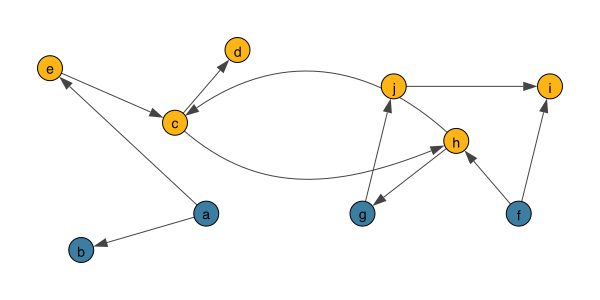

In [4]:
# create a simple network for illustration
# NOTE: this is the network used to exposit the schlaufe algorithm introduced in the paper.

# adjacency matrix for example graph
adj_m = np.zeros((10,10))
adj_m[0,1] = 1 # a b
adj_m[0,4] = 1 # a e
adj_m[4,2] = 1 # e c
adj_m[2,3] = 1 # c d
adj_m[2,7] = 1 # c h
adj_m[7,2] = 1 # h c
adj_m[7,6] = 1 # h g
adj_m[6,9] = 1 # g j
adj_m[9,8] = 1 # j i
adj_m[5,8] = 1 # f i
adj_m[5,7] = 1 # f h

# vertex labels for example graph
vertex_labels =    ["a", "b", "c", "d", "e", \
                    "f", "g", "h", "i", "j"]

# vertex positions (for plotting purposes)
vertex_positions = [(5, 5),     (1, 6),    (4, 2.5),  (6, 0.5),  (0, 1.0),\
                    (15, 5),   (10, 5),   (13, 3),  (16, 1.5),  (11, 1.5)]

# vertex colors
vertex_colors =    ["#3B7EA1", "#3B7EA1", "#FDB515",  "#FDB515",   \
                    "#FDB515", "#3B7EA1", "#3B7EA1",  "#FDB515",  "#FDB515",  "#FDB515"]

# create igraph object and plot it
igraph.plot(get_graph(adj_m, vertex_labels), labels = True, layout = vertex_positions, \
            vertex_color = vertex_colors, margin = 50, marginTop = 600, \
            vertex_size = 25, rescale = False, bbox = (0, 0, 600, 300))

Next we use the **digraph_hyp_test()** function in the **ugd** module to simulate networks with the same degree sequence as the graph shown immediately above. Typing _help(ugd.digraph_hyp_test)_ returns more information about this function. Key parameters to choose are *mixing_time*, which we set to 100, meaning we do 100 rounds of edge swaps before we consider the graph generated to be a draw from the target set. Because this illustration graph is small, a large fraction of edges are swapped at each step of the algorithm, hence we expect the process to "mix" quickly (and hence yield a draw from the target ergodic distribution relatively quickly).    

How to choose the *mixing_time* parameter in larger graphs, with complex cross link constraints (where a longer burn in time may be needed), is discussed more in the context of the Nyakatoke risk-sharing empirical example below.  

For this example we set *anz_sim = 1*, indicating we wish to simulate just one single graph with the target degree sequence.

In [5]:
help(ugd.digraph_hyp_test)

Help on function digraph_hyp_test in module ugd.high_level_interface.user_interface:

digraph_hyp_test(adj_m, var_dict=None, stat_f=None, test_variable=None, controls=None, mixing_time=None, anz_sim=1000, show_plot=False, fast_mixing_time_evaluation=False)
    OVERVIEW: This function generates random digraphs with given in- and out- degree sequences 
              and "cross-arrow" (or cross-link) restrictions. Digraphs are drawn uniformly at 
              random from the set of all labeled graphs obeying the given constraints. The simulated
              digraphs are used to estimate the H0/Null distribution of a test statistic. Further 
              explanation of methods is given in the paper : “An optimal test for strategic 
              interaction in social and economic network formation between heterogeneous agents” by
              Andrin Pelican and Bryan Graham (see https://arxiv.org/abs/2009.00212).
    
    
    INPUT:
    ------------------------------------------------

In [6]:
simulation_dict = ugd.digraph_hyp_test(adj_m = adj_m, mixing_time = 50, anz_sim = 1, show_plot=False)

INFO:root:Approximate time to draw one graph from the reference set                           : 0.005231 s
INFO:root:Total execution time is estimated at                                                : 0 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 810%.


The function returns a dictionary. The 'graph_list' key of the dictionary returns a list of simulated adjacency matrices. This feature can be useful for save simulation draws from the null distribution for later (or repeated processing).   

The adjacency matrix simulated above is printed out below and also plotted. Note that the in- and out-degree sequence of the simulated graph is the same as that of the input graph.

In [7]:
simulation_dict['graph_list'][0]

array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

While the in- and out-degree sequence of the simulated graph is the same as the original graph, the number of links across nodes of different colors is not be constrained to stay the same (see the figure below).

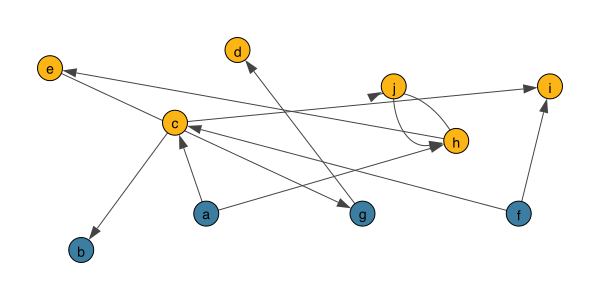

In [8]:
# Plot the first simulated graph
igraph.plot(get_graph(simulation_dict['graph_list'][0], vertex_labels), labels = True, layout = vertex_positions, \
            vertex_color = vertex_colors, margin = 50, marginTop = 600, \
            vertex_size = 25, rescale = False, bbox = (0, 0, 600, 300))

Next we show how to additionally constrain the simulated graphs to preserve the number of directed edges sent between vertices of different colors (i.e., we impose the cross link matrix constraint along with the degree sequence one). This generates reference graphs that control for "homophily" as well as "degree heterogeneity" as described in the paper. The ability to imposes the cross link constraint, sometimes called the partition adjacency matrix (PAM) constraint in the discrete math / graph theory literature, it the key "new" feature of our simulation algorithm. Many algorithms for the simulation of digraphs with fixed in- and out-degrees sequences are available. See the paper for more discussion and references.    

In order to imposes the cross link constraint we need to create a *node_attribute* dictionary which partitions nodes into $K$ different types. In the current example $K=2$ since nodes are either blue or gold.

In [10]:
# Create dictionary of attributes for each vertex in the graph. This is needed as an argument 
# in digraph_hyp_test() in order to impose the cross link matrix constrain.
node_attributes ={
    0: {'color': 'blue'},
    1: {'color': 'blue'},
    2: {'color': 'gold'},
    3: {'color': 'gold'},
    4: {'color': 'gold'},
    5: {'color': 'blue'},
    6: {'color': 'blue'},
    7: {'color': 'gold'},
    8: {'color': 'gold'},
    9: {'color': 'gold'},
}


# We explicitly specify that we want to impose the implied cross link matrix for the node attribute "color"
simulation_dict = ugd.digraph_hyp_test(adj_m=adj_m, mixing_time=100, anz_sim=1, \
                                       var_dict=node_attributes, controls= ["color"],  show_plot=False)

INFO:root:Approximate time to draw one graph from the reference set                           : 0.013034 s
INFO:root:Total execution time is estimated at                                                : 0 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 1190%.


Now the simulated graph also shares the same cross link matrix as the target graph.

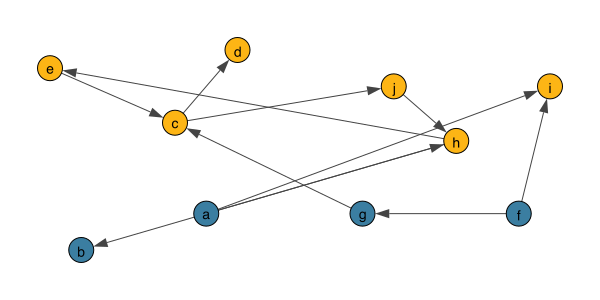

In [11]:
# Plot the first simulated graph
igraph.plot(get_graph(simulation_dict['graph_list'][0], vertex_labels), labels = True, layout = vertex_positions, \
            vertex_color = vertex_colors, margin = 50, marginTop = 600, \
            vertex_size = 25, rescale = False, bbox = (0, 0, 600, 300))

### An illustrative testing example
Next we show how to use the *digraph_hyp_test()* function to conduct a model adequacy test. The idea is to pick a statistic of the adjacency matrix, perhaps heuristically, and simulate its null distribution. This null distribution is the one induced by a discrete uniform distribution across all labelled digraphs with the same in- and out-degree sequences and same cross link matrix as the digraph in hand. If our statistic is in the tail of the null distribution, this can be taken as evidence against the null. For illustration purposes we simulate the null distribution of the reciprocity index.    

Note that the null model also corresponds to the model of directed link formation studied by Charbonneau (2017, _Econometrics Journal_); who emphasized its exponential family structure.   


The *digraph_hyp_test()* function includes a "show_plot" option which, when set equal to TRUE, prints out a histogram of the simulated null distribution and a vertical bar showing the value of the statistic in the network in hand. A p-value is also reported as part of the test output.       

To implement the model adequacy test we need to write a function which takes a network adjacency matrix and dictionary of node attributes as inputs and returns a scalar-valued statistic. For this illustration we use the reciprocity index as the network statistic. A function which computes the reciprocity index is defined in the next snippet of code.   

To implement the test we take a thousand draws from the null distribution.

INFO:root:Approximate time to draw one graph from the reference set                           : 0.011582 s
INFO:root:Total execution time is estimated at                                                : 11 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 1169%.


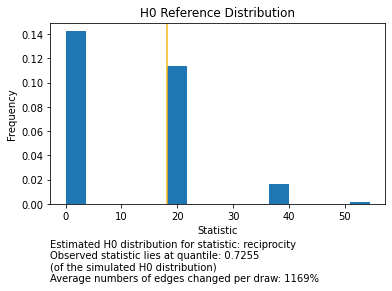

In [12]:
# NOTE: although our statistic doesn't vary with node attributes, we include this as an argument 
#       since _digraph_hyp_test()_ allows for / expects it.

def reciprocity(adj_m, node_attributes):
    
    """Calculate the reciprocity index from the adjacency matrix of a directed graph."""
    
    # Count the number of reciprocal dyads (note this actually double counts such dyads)
    r1 = np.sum(adj_m * np.transpose(adj_m))
    
    # Count the number of edges
    r2 = np.sum(adj_m)
        
    # Reciprocity index (rescaled to lie between zero and 100)
    R = (r1/r2)*100
    
    return R

simulation_dict = ugd.digraph_hyp_test(adj_m = adj_m, stat_f = reciprocity,  \
                                       mixing_time = 100, anz_sim = 1000, var_dict = node_attributes, \
                                       controls= ["color"],  show_plot=True)

Next we construct the *locally most powerful* test as described in the paper. This requires defining a function that returns $s_{ij}\left(\mathbf{d}\right)$, the marginal network benefit of edge $ij$ as defined in the paper. The form of $s_{ij}\left(\mathbf{d}\right)$ depends on the network benefit function, $g_i\left(\mathbf{d}\right)$, specified by the researcher. Several examples are given in the paper.   

The function we need to define returns a *matrix* of such marginal benefits, one for each possible directed edge in the network. When agents have a taste for reciprocity as described in the paper we have that $s_{ij}\left(\mathbf{d}\right)=d_{ji}$. This means we can just use the transpose of the adjacency matrix for the needed marginal benefit function (see below). More complicated examples, including ones where the matrix of $s_{ij}\left(\mathbf{d}\right)$ terms needs to be computed numerically, can be found below.   

The locally best test statistic depends on the homophily and degree heterogeneity nuisance parameters. In order to implement a feasible test we replace these parameters with their joint maximum likelihood estimates. Yan, T., Jiang, B., Fienberg, S. E., and Leng, C. (2018). "Statistical inference in a directed network model with covariates," *Journal of the American Statistical Association* 114 (526): 857 - 868 provides a detailed analysis of MLE computation for the null model. Note that for certain configurations of the network, the MLE of the nuisance parameter $\delta$ will not exist (similar to the problem of complete separation in logit classication analysis). However in this case the MLEs of the link probabilities *are* still well defined (albeit some will be exactly zero or one); it is these latter objects that enter the optimal test statistic (so there are no problems). Note also that the sufficient statistics for $\delta$ are invariant across all the simulated networks, therefore $\delta$ only needs to be estimated once, using the graph in hand. The **ugd** package takes care of all these details.    

The following snippett of code defines a function which returns the matrix of marginal link utilities and then simulates the null distribution of the locally best test statistic.

INFO:root:A total of 39 directed dyads are excluded from estimation because they include a sparse node (one with no arcs directed in or out or due to a sparse group constraint.
INFO:root:Maximum gradient entry at the MLE: 2.220446049250313e-16
INFO:root:Eigenvalues of Hessian matrix:     
INFO:root:maximal: 2.208451329102581  minimal: 0.0965594478349081


Optimization terminated successfully.
         Current function value: 0.487018
         Iterations 6


INFO:root:Approximate time to draw one graph from the reference set                           : 0.010457 s
INFO:root:Total execution time is estimated at                                                : 10 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 1171%.


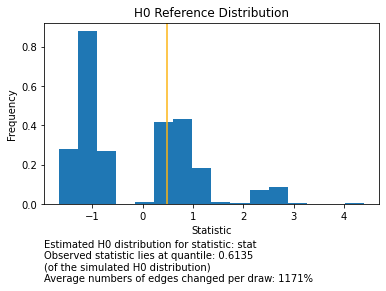

In [13]:
# testing whether there is structural taste for reciprocity:
def s_ij_reciprocity(adj_m):
    
    """Returns matrix of marginal network benefits for each possible arc when agents have a
       structural taste for reciprocity."""
    
    # reciprocity -> i gets more utility from an edge to j when j directs an edge to i (i.e., reciprocates)
    return np.transpose(adj_m)

# this function takes the s_ij matrix defined above a constructs the locally best test statistic
# NOTE: This requires maximum likelihood estimation of the null model.
optimal_stat_for_reciprocity = ugd.make_lcl_mst_pwf_stat(adj_m, edge_util_function = s_ij_reciprocity)

# finally we simulate the null distribution of the locally best test statistic
simulation_dict = ugd.digraph_hyp_test(adj_m = adj_m, stat_f = optimal_stat_for_reciprocity,  \
                                       mixing_time = 100, anz_sim = 1000, var_dict = node_attributes, \
                                       controls = ["color"],  show_plot = True)

# Empirical example: Nyakatoke risk-sharing network    
de Weerdt (2002) collected and analyzed a network of risk sharing links among households in the Tanzanian village of Nyakatoke. Individuals in this village were asked to "give a list of people from inside or outside of Nyakatoke, who you can personally rely on for help and/or that can rely on you for help in cash, kind or labour”. From these responses de Weerdt (2002) constructed a directed network of support links. de Weerdt (2002), noting that the edge generation prompt suggests mutuality, projected the directed network onto an undirected one. We instead, analyze the primitive directed links; Comola and Fafchamps (2014, *Economic Journal*) provide evidence in support of this approach. They suggest that the given links actually represent a household's views about who they would _ask_ for help in a time of need (i.e., desired links).

The Nykatoke link and household attribute data used in our analysis are loaded in the next snippet of code. From de Weerdt (2002) we know that household land and livestock wealth, as well as household religion, are important sources of homophily in links. We therefore define $K=9$ household types by partitioning households into all nine combinations of three wealth groups (poor, middle, rich) and three religion groups (Muslim, Lutheran and Catholic). We convert land and livestock wealth in Tanzanian Shillings following Comola and Fafchamps (2014).

In [17]:
# Load list of Arcs/Edges
Nyakatoke_ArcList = np.load(data + "Nyakatoke_ArcList.npy")

# Load household attribute dictionary
Nyakatoke_AttrDict = np.load(data + "Nyakatoke_AttrDict.npy", allow_pickle=True)
Nyakatoke_AttrDict = dict(enumerate(Nyakatoke_AttrDict.flatten(), 1))[1]

Next we re-organize the household attribute data such that the dictionary Keys run from zero to 118, not the three character string keys used above. This is needed to make the attribute data compatible with the **ugd** functions called below. We also create a dictionary mapping household types to integers (to make calculating assortativity easier) and another dictionary mapping household types to colors (for network plotting).

In [18]:
i = 0
Nyakatoke_X  = {}
Nyakatoke_color = {}

for hh in Nyakatoke_AttrDict:    
    Nyakatoke_X.setdefault(i,Nyakatoke_AttrDict[hh])
    i = i + 1
   
asst_dict = {"poor_X_Muslim" : 0, "poor_X_Lutheran" : 1, "poor_X_Catholic" : 2, \
             "middle_X_Muslim" : 3, "middle_X_Lutheran" : 4, "middle_X_Catholic" : 5, \
             "rich_X_Muslim" : 6, "rich_X_Lutheran" : 7, "rich_X_Catholic" : 8}   

color_dict = {0 : "#00A598", 1 : "#D9661F", 2 : "#003262", \
              3 : "#CFDD45", 4 : "#EE1F60", 5 : "#3B7EA1", \
              6 : "#859438", 7 : "#ED4E33", 8 : "#00B0DA"}    


N = len(Nyakatoke_AttrDict)   # Number of households in Nyakatoke
M = len(Nyakatoke_ArcList)    # Number of arcs in Nyakatoke   

Next we create an iGraph representation of the Nyakatoke network. This allows us to use some of the built in functionality of iGraph (e.g., algorithms for calculing the shortest path length between nodes) and also facilitates plotting of the network.

In [19]:
G = igraph.Graph(directed=True)
G.add_vertices(list(Nyakatoke_AttrDict.keys()))
G.add_edges(Nyakatoke_ArcList)
G.vs['wealth_X_religion'] = [asst_dict[Nyakatoke_AttrDict[hh]['wealth_X_religion']] for hh in Nyakatoke_AttrDict]  

# layout for plotting
layout = G.layout("mds")

# network adjacency matrix
D = np.array(list(G.get_adjacency()))

This snippet of code reproduces the plot the Nyakatoke network which appears in the paper.

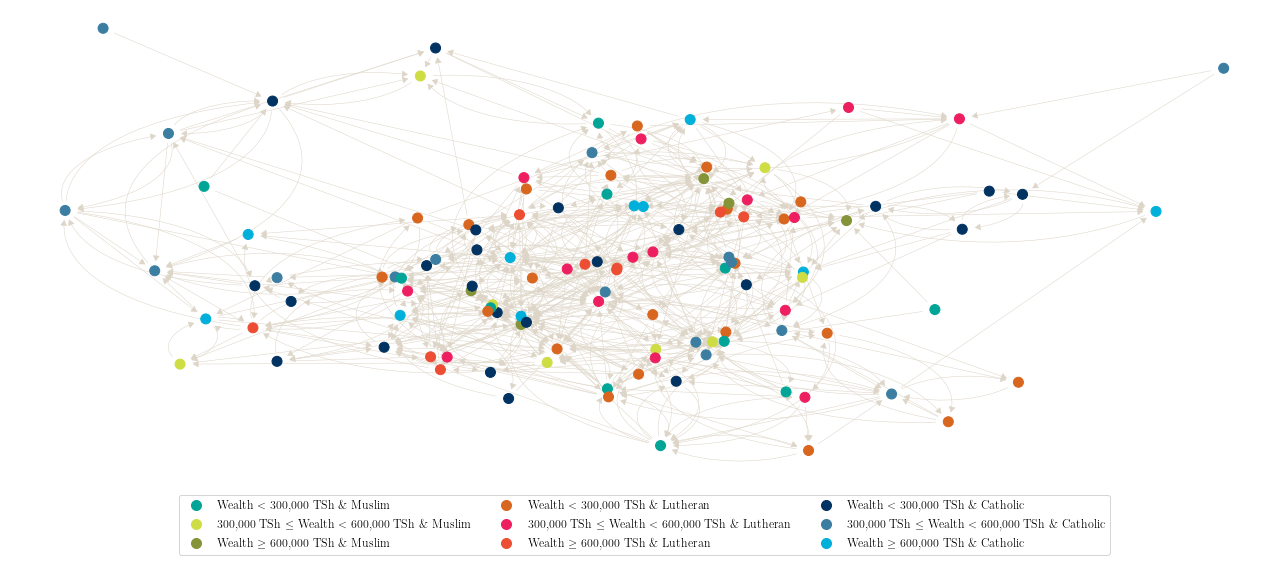

In [20]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(18,9))
plt.axis('off') 

igraph.plot(G, labels = True, layout = layout, \
            vertex_color=[color_dict[x] for x in G.vs["wealth_X_religion"]], 
            edge_arrow_size = 5, edge_arrow_width = 3, edge_width = 0.5, edge_color = "#DDD5C7", \
            vertex_size = 10, target = ax)
                             
# Legend items for node types
poor_X_Muslim_patch     = Line2D([0], [0], color='#00A598', marker='o', linestyle='None',\
                                  markersize=10)
poor_X_Lutheran_patch   = Line2D([0], [0], color='#D9661F', marker='o', linestyle='None',\
                                 markersize=10)
poor_X_Catholic_patch   = Line2D([0], [0], color='#003262', marker='o', linestyle='None',\
                                 markersize=10)

middle_X_Muslim_patch   = Line2D([0], [0], color='#CFDD45', marker='o', linestyle='None',\
                                 markersize=10)
middle_X_Lutheran_patch = Line2D([0], [0], color='#EE1F60', marker='o', linestyle='None',\
                                 markersize=10)
middle_X_Catholic_patch = Line2D([0], [0], color='#3B7EA1', marker='o', linestyle='None',\
                                 markersize=10)

rich_X_Muslim_patch     = Line2D([0], [0], color='#859438', marker='o', linestyle='None',\
                                 markersize=10)
rich_X_Lutheran_patch   = Line2D([0], [0], color='#ED4E33', marker='o', linestyle='None',\
                                 markersize=10)
rich_X_Catholic_patch   = Line2D([0], [0], color='#00B0DA', marker='o', linestyle='None',\
                                 markersize=10)


legend_labels = [r'Wealth $<$ 300,000 TSh \& Muslim', r'300,000 TSh $\leq$ Wealth $<$ 600,000 TSh \& Muslim', \
                 r'Wealth $\geq$  600,000 TSh \& Muslim', \
                 r'Wealth $<$ 300,000 TSh \& Lutheran', r'300,000 TSh $\leq$ Wealth $<$ 600,000 TSh \& Lutheran', \
                 r'Wealth $\geq$  600,000 TSh \& Lutheran', \
                 r'Wealth $<$ 300,000 TSh \& Catholic',  r'300,000 TSh $\leq$ Wealth $<$ 600,000 TSh \& Catholic', \
                 r'Wealth $\geq$  600,000 TSh \& Catholic']

# Add legend and save figure
plt.tight_layout(rect=[0,0.25,1,1])
fig.legend(handles=[poor_X_Muslim_patch, middle_X_Muslim_patch, rich_X_Muslim_patch, \
                         poor_X_Lutheran_patch, middle_X_Lutheran_patch, rich_X_Lutheran_patch, \
                         poor_X_Catholic_patch, middle_X_Catholic_patch, rich_X_Catholic_patch], \
                         labels=legend_labels, \
                         bbox_to_anchor=(0.5, 0.24), loc='upper center', fontsize=12, ncol=3, numpoints = 1) 
plt.savefig(graphics+'Nyakatoke_Network.png', dpi=500)

## Model adequacy testing: assessing transitivity and structural holes

Here we show how to use **ugd** to implement tests of model adequacy in the context of the Nyakatoke risk-sharing network. This provides a realistic application of our methods.

First we test for whether the Nyakatoke network is significantly transitive relative to three reference distributions of graphs: (i) Erdos-Renyi random graphs with the same number of links as observed in Nyakatoke, (ii) the set of graphs with the same in-degree and out-degree sequences as observed Nyakatoke, and, finally, (iii) the set of graphs which additionally control for wealth-by-religion homophily (as well as degree heterogeneity). We implement this test with a directed measure of network transitivity due to Wasserman and Faust (1994, p. 243). For all triples $i$, $j$ and $k$, we count the frequency with which arc $ik$ is present conditional on arcs $ij$ and $jk$ also being present. This example is included here as it is easier to understand and familiar. It is not reported in the paper.    

The example reported in the paper represents an attempt to explore the relevance of Burt's (1995, _Structural Holes:
The Social Structure of Competition_) theory of "structural holes". Burt hypothesized that agents derive utility/advantages from bridging otherwise unconnected individuals. For example if _i_ is connected to _j_ and _j_ to _k_, but _i_ is not directly connected to _k_, then _j_ serves as a bridge between _i_ and _k_. This is potentially valuable to _j_ because she is able to mediate the flow of information and resources from _i_ to _k_.    

Unlike a taste for transitive closure, it is not entirely obvious what an heuristic test statistic for Burt's (1995) theory would look like. Positioning oneself in a way which generates bridging capital is difficult to do as it is inherential rivalrous (the addition of a few links by other agents -- for example -- can destroy an agents' bridging capital). In the case of transitivity, on the other hand, adding links to the network never lowers other agents utility.   

As noted above ,bridging capital is inherentially rivalrous. To capture this idea heuristically we look at the dispersion of _betweenness centrality_ across agents; hypothesizing that if agents value betweenness, then its dispersion should be high relative to the reference distribution. This captures the idea that other some agents will suceed in becoming "brokers" in equilibrium.  

To implement both sets of tests we need to write a function which takes the network adjacency matrix as an input, and returns the scalar statistic whose null distribution we wish to simulate as an output. This is what the *transitivity()* and *brokerage()* functions defined immediately below do.   

Users can use these two functions as models in order to implement their own model adequacy tests.

In [21]:
def transitivity(adj_m, node_attributes):
    
    """Compute transitivity index associated with the digraph with adjacency matrix adj_m"""
    
    [N, N] = np.shape(adj_m)
    
    # Initialize numerator and denominator of transitivity index
    non_trivial = 0
    transitive  = 0
        
    # loop over all ordered triples
    for triad in itertools.permutations(range(0,N), r=3):
        [i, j, k] = triad
        non_trivial = non_trivial + adj_m[i,j]*adj_m[j,k]
        transitive = transitive + adj_m[i,j]*adj_m[j,k]*adj_m[i,k]
        
    # return fraction of all non-vacuous triples that are transitive, rescale to index
    # to lie between 0 and 100
     
    return (transitive/non_trivial)*100

In [50]:
def betweenness(adj_m, node_attributes):
    """Compute betweennness centrality for all agents in the network and calculate its standard deviation across
       agents."""
    
    # create igraph object from adjacency matrix
    G     = igraph.Graph.Adjacency((adj_m > 0).tolist())
    
    # Calculate 10 and 90th percentiles of betweenness centrality in the network
    [p25, p75] = np.percentile(G.betweenness(), q = [50,90])
    
    # Calculate the std dev of betweenness centrality in the network
    #std = np.std(G.betweenness())
    
    return p75-p25           

First we simulate $B = 1000$ Erdos-Renyi random digraphs with density identical to that observed in Nyakatoke. We compute transitivity and betweenness dispersion on each simulated graph and save the results.

In [51]:
B = 100

# initialize stat_lists
stat_list_RG_transitivity = []
stat_list_RG_holes  = []

# get off-diagonal adjacency matrix indices
ij_u = np.triu_indices(N, k=1)
ij_l = np.tril_indices(N, k=-1)
ij   = np.hstack((ij_l,ij_u))

# Number of directed dyads in the network
n    = np.shape(ij)[1]          

for b in range(0,B):
    
    # Initialize adjacency matrix
    D_b = np.zeros((N,N))
    
    # Draw M directed arcs at random, without replacement
    random_arcs = np.random.choice(n, size=M, replace=False)
    D_b[ij[0,random_arcs],ij[1,random_arcs]] = 1
    
    
    # Compute network statistics and add to appropriate stat_list
    stat_list_RG_transitivity.append(transitivity(D_b, []))
    stat_list_RG_holes.append(betweenness(D_b, []))    

### Assessing transitivity

Next we simulate $B=1000$ degree constrained digraphs (and similarly for digraphs which additionally impose the cross link constraint). Note that we need to set the mixing time parameter to a much larger value when imposing the cross link constraint. This is because, with the addition of this constraint, it takes more steps of our algorithm to ensure that the simulated graph is sufficiently far from the starting graph to be safely considered a uniform random draw from the reference set. A rule-of-thumb which we have found useful is to set *mixing_time* to a value which ensures that the number of edges "swapped" in the graph is at least as big as the number of edges in the graph.    

To calibrate the *mixing_time* parameter in practice use the *function ugd.digraph_hyp_test()* function output. This output reports the "Approximate number of edges changed per simulated graph (as a percent of all edges)". Start with some experiments with *anz_sim* set equal to 1. In these experiments vary the *mixing_time* until you get an estimate that ensures roughly all edges are swapped once or twice in expectation.


This gives some sense of the implications of high dimensional covariate spaces for the computational feasibility of our algorithm. Note user with large graphs and/or complicated cross link matrix constraints will likely want to parallelize their simulations.

INFO:root:Approximate time to draw one graph from the reference set                           : 0.198051 s
INFO:root:Total execution time is estimated at                                                : 198 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 206%.


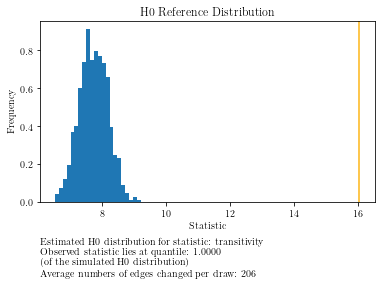

INFO:root:Approximate time to draw one graph from the reference set                           : 15.202706 s
INFO:root:Total execution time is estimated at                                                : 15202 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 133%.


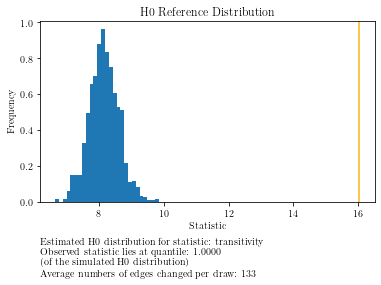

In [21]:
simulation_dict_DC_transitivity    = ugd.digraph_hyp_test(adj_m = D, stat_f = transitivity,  \
                                                          mixing_time = 250, anz_sim = B,  show_plot=True)

simulation_dict_DC_CL_transitivity = ugd.digraph_hyp_test(adj_m = D, stat_f = transitivity,  \
                                                          mixing_time = 10000, anz_sim = B, var_dict = Nyakatoke_X, \
                                                          controls= ["wealth_X_religion"],  show_plot=True)

### Assessing structural holes
This next snippet of code repeats the analysis for the dispersion of betweenness centrality statistic. This is the model adequacy example reported in the paper

INFO:root:Approximate time to draw one graph from the reference set                           : 0.526129 s
INFO:root:Total execution time is estimated at                                                : 52 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 221%.


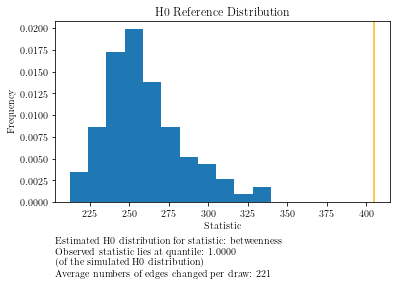

INFO:root:Approximate time to draw one graph from the reference set                           : 38.725257 s
INFO:root:Total execution time is estimated at                                                : 3872 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 180%.


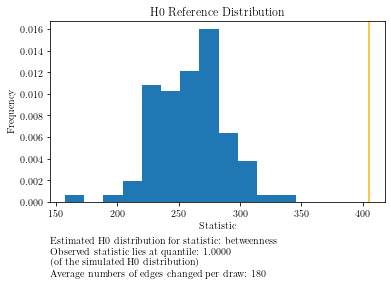

In [52]:
simulation_dict_DC_holes    = ugd.digraph_hyp_test(adj_m = D, stat_f = betweenness,  \
                                                       mixing_time = 250, anz_sim = B,  show_plot=True)

simulation_dict_DC_CL_holes = ugd.digraph_hyp_test(adj_m = D, stat_f = betweenness,  \
                                                       mixing_time = 10000, anz_sim = B, var_dict = Nyakatoke_X, \
                                                       controls= ["wealth_X_religion"],  show_plot=True)

## Testing for structural taste for transitivity and brokerage/betweenness

Next we implement a "structural" tests using the Nyakatoke network. Our structural test for whether agents value transitivity in links is straightforward. This material is not reported in the paper. Our "structural holes" test is more complicated. This is the example we do report upon in the paper.    

Specifically, our test is inspired by the network formation model analyzed in the following paper:  

Jon Kleinberg, Siddharth Suri, Tom Wexler and Eva Tardos. (2008). "Strategic network formation with structural holes", _EC '08: Proceedings of the 9th ACM conference on Electronic commerce_: 284–293.    

The premise of this paper is that individuals value the ability to broker/mediate interactions between otherwise unconnected nodes. This example is described in the paper, as are the details of the specific network benefit function used for implementation.    

This example is interesting because (i) as noted above, it is not obvious what form a heuristic test statistic with power for the alternative, "households like to be intermmediaries" should take and (ii) the form of the optimal test statistic is relatively complicated (although it does exist in quasi-closed form). Indeed we view the tight mapping from theory to test statistic to be very useful in certain settings (like this one).   

To implement locally best structural tests as described in the paper we need to write a function which returns an $ N \times N$ matrix of marginal network utilities (i.e., a matrix with elements $s_{ij}(\mathbf{d})$ as described in the paper). We can be quite flexible here, for example $s_{ij}(\mathbf{d})$ need not exist in "closed form", but can instead be calculated numerically.

Below are three $s_{ij}(\mathbf{d})$ functions. Users can adapt these examples to suit their own interests.    

The first gives the appropriate marginal network benefits in the presence of a structural taste for transitivity.   

The second gives the appropriate marginal network benefits for our variant of the Kleinberg et al. (2008) model. This function is used for the results reported in the paper.    

The third gives the appropriate marginal network benefits for a version of the Bala and Goyal (2000, _Econometrica_) "connections" model. This last example is useful because it illustrates how the $s_{ij}(\mathbf{d})$ can be computed numerically.

In [25]:
def s_ij_transitivity(adj_m):
    
    """This function constructs a matrix of network benefit marginal utilities for
       each possible edge ij when agents have a taste for transitive links."""
    
    # initialize matrix recording the network component of marginal link utilities
    [N, N] = np.shape(adj_m)
    s      = np.zeros((N,N))
        
    # loop over all directed dyads
    for triad in itertools.permutations(range(0,N), r=3):
        [i, j, k] = triad
        s[i,j] = s[i,j] + adj_m[i,k]*adj_m[k,j] + adj_m[i,k]*adj_m[j,k] 
     
    return s

In [46]:
def s_ij_holes(adj_m):
    
    """This function constructs a matrix of network benefit marginal 
    utilities for each possible edge ij when like to be brokers."""
    
    # initialize matrix recording the network component of marginal link utilities
    [N, N] = np.shape(adj_m)
    s      = np.zeros((N,N))
    
    hole_3d_array = np.zeros((N,N,N), dtype=np.float32)
    
    for triad in itertools.permutations(range(0,N), r=3):
        [i, j, k] = triad
        hole_3d_array[i,j,k] = D[k,i]*D[i,j]*(1-D[k,j])
        
    
    bridges_between_jk = np.sum(hole_3d_array, axis = 0)
    denominator_ij = np.repeat(bridges_between_jk[np.newaxis,:, :], N, axis=0)    
    denominator_ij = np.where(denominator_ij > 0, denominator_ij, 1)    
    s = np.sum(hole_3d_array / denominator_ij, axis = 2)
    
    
    return s

In [47]:
def s_ij_connections(adj_m):
    
    """
    This function returns a matrix of marginal network benefits for each of the N(N-1)
    possible directed ij links/arcs in the communications model analyzed in Bala and Goyal (2000). 
    As in Bala and Goyal (2000), while links are directed, information is assumed to flow in 
    both directions on all links. The marginal network benefit of edge ij for agent i equals 
    its effect on discounted distance to all other agents in the network. We set the discount
    parameter to delta = 2/3 and truncate any benefits a path distance of three or more away
    to zero.
    """
    
    # initialize matrix recording the network component of marginal link utilities
    [N, N] = np.shape(adj_m)
    s      = np.zeros((N,N))
    
    # decay rate for indirect connections
    delta      = 2/3 
    
    # truncation level for path distances
    K           = 3
    
    # create igraph object from adjacency matrix
    G = igraph.Graph.Adjacency((adj_m > 0).tolist())
    
    # loop over all directed dyads
    for dyad in itertools.permutations(range(0,N), r=2):
        [i, j] = dyad
        if (i, j) in set(G.get_edgelist()):   
            # CASE 1: edge ij is present in network
            G_add_ij   = G.copy()
            G_sub_ij   = G.copy()
            G_sub_ij.delete_edges([(i,j)])
        else:
            # CASE 2: edge ij is not present in network
            G_add_ij   = G.copy()
            G_add_ij.add_edges([(i,j)])
            G_sub_ij   = G.copy()
    
    
        # Compute truncated distance matrices
        distance_vector_add_ij = np.array(G_add_ij.shortest_paths(source=i,mode='all'))
        distance_vector_add_ij = np.where(distance_vector_add_ij>K,np.inf,distance_vector_add_ij)
        
        distance_vector_sub_ij = np.array(G_sub_ij.shortest_paths(source=i,mode='all'))
        distance_vector_sub_ij = np.where(distance_vector_sub_ij>K,np.inf,distance_vector_sub_ij)
        
        
        # compute marginal network benefit of edge ij
        s[i,j] = np.sum(delta**(distance_vector_add_ij)) \
                -np.sum(delta**(distance_vector_sub_ij))
    return s  

### A structural test for transitivity in preference

The next few snippets of code report the results of a locally best test for an alternative where agents have a structural taste for transitivity in links. These results are not reported in the paper.

INFO:root:A total of 1512 directed dyads are excluded from estimation because they include a sparse node (one with no arcs directed in or out or due to a sparse group constraint.
INFO:root:Maximum gradient entry at the MLE: 2.6645352591003757e-15
INFO:root:Eigenvalues of Hessian matrix:     
INFO:root:maximal: 18.284040112273175  minimal: 0.020551333286888518


Optimization terminated successfully.
         Current function value: 0.179232
         Iterations 9


INFO:root:Approximate time to draw one graph from the reference set                           : 14.946671 s
INFO:root:Total execution time is estimated at                                                : 14946 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 198%.


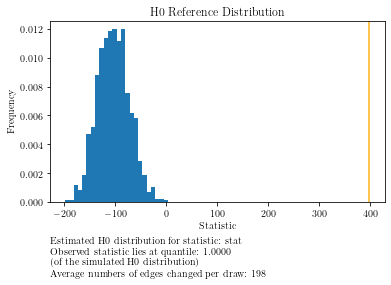

In [25]:
optimal_stat_for_transitivity = ugd.make_lcl_mst_pwf_stat(D, edge_util_function = s_ij_transitivity)
simulation_dict_LB_transitivity = ugd.digraph_hyp_test(adj_m = D, stat_f = optimal_stat_for_transitivity,  \
                                                       mixing_time = 10000, anz_sim = B, var_dict = Nyakatoke_X, \
                                                       controls = ['wealth_X_religion'],  show_plot = True)

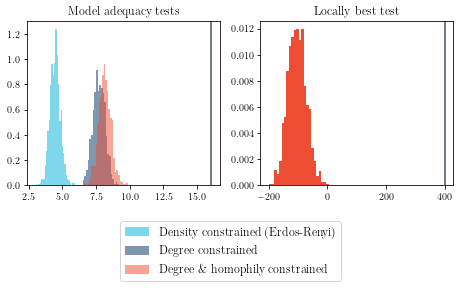

In [26]:
# Actual transitivity in Nyakatoke
transitivity_actual = transitivity(D, []);
s_ij_transitivity_actual = simulation_dict_LB_transitivity['info_dict']['original_value']

# Plot the simulation results
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6.5,4))

colors = ['#00B0DA', '#003262', '#ED4E33']

# Plot goodness-of-fit test with three reference distributions
ax0.hist(stat_list_RG_transitivity, \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[0], label = r'Density constrained (Erdos-Renyi)')
ax0.hist(simulation_dict_DC_transitivity['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[1], label = r'Degree constrained')
ax0.hist(simulation_dict_DC_CL_transitivity['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[2], label = r'Degree \& homophily constrained')


ax0.set_title('Model adequacy tests')
ax0.axvline(x=transitivity_actual, color="#46535E")

# Plot structural test of connections model
ax1.hist(simulation_dict_LB_transitivity['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=1, color = colors[2], label = 'Locally best test')

ax1.set_title('Locally best test')
ax1.axvline(x=s_ij_transitivity_actual, color="#46535E")


handles, labels = ax0.get_legend_handles_labels()

# Add legend and save figure
plt.tight_layout(rect=[0,0.25,1,1])
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.24), fontsize=12)
plt.savefig(graphics+'Nyakatoke_Transitivity.png', dpi=500)

### A structural test for brokerage/mediation preferences

The next few snippets of code report the results of a locally best test for an alternative where agents like to be brokers. These are the results reported in the paper.

INFO:root:A total of 1512 directed dyads are excluded from estimation because they include a sparse node (one with no arcs directed in or out or due to a sparse group constraint.
INFO:root:Maximum gradient entry at the MLE: 2.4147350785597155e-15
INFO:root:Eigenvalues of Hessian matrix:     
INFO:root:maximal: 18.28404011227319  minimal: 0.020551333286905504


Optimization terminated successfully.
         Current function value: 0.179232
         Iterations 9


INFO:root:Approximate time to draw one graph from the reference set                           : 28.147342 s
INFO:root:Total execution time is estimated at                                                : 2814 s
INFO:root:Approximate number of edges changed per simulated graph (as a percent of all edges) : 185%.


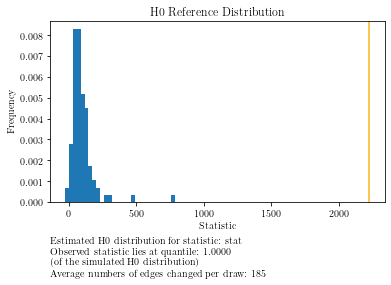

In [53]:
optimal_stat_for_holes = ugd.make_lcl_mst_pwf_stat(D, edge_util_function = s_ij_holes)
simulation_dict_LB_holes = ugd.digraph_hyp_test(adj_m = D, stat_f = optimal_stat_for_holes,  \
                                       mixing_time = 10000, anz_sim = B, var_dict = Nyakatoke_X, \
                                       controls = ['wealth_X_religion'],  show_plot = True)

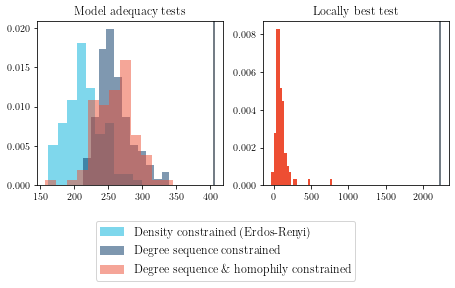

In [54]:
betweenness_actual = betweenness(D, []);
s_ij_holes_actual  = simulation_dict_LB_holes['info_dict']['original_value']

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6.5,4))

colors = ['#00B0DA', '#003262', '#ED4E33']

# Plot goodness-of-fit test with three reference distributions
ax0.hist(stat_list_RG_holes, \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[0], label = r'Density constrained (Erdos-Renyi)')
ax0.hist(simulation_dict_DC_holes['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[1], label = r'Degree sequence constrained')
ax0.hist(simulation_dict_DC_CL_holes['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=0.5, color = colors[2], label = r'Degree sequence \& homophily constrained')


ax0.set_title('Model adequacy tests')
ax0.axvline(x=betweenness_actual, color="#46535E")

# Plot structural test of connections model
ax1.hist(simulation_dict_LB_holes['stat_list'], \
         bins='auto', histtype='stepfilled', \
         density=True, alpha=1, color = colors[2], label = 'Locally best test')

ax1.set_title('Locally best test')
ax1.axvline(x=s_ij_holes_actual, color="#46535E")

handles, labels = ax0.get_legend_handles_labels()

# Add legend and save figure
plt.tight_layout(rect=[0,0.25,1,1])
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.24), fontsize=12)
plt.savefig(graphics+'Nyakatoke_Brokerage.png', dpi=500)

# Conclusion
Hopefully the basic examples provided in this notebook can be adapted to applications of interest to you. While we are not in a position to offer extensive support for the **ugd()** module you are welcome to ask questions and we wil do our best to respond. We welcome bug reports as well. Please feel free to make use of the code in your own research (including modifications and improvements). We just ask that you cite our paper (https://arxiv.org/abs/2009.00212).